In [1]:
import json, os, sys
%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# from utils import session_config
# session_config.setup_gpus(True, 0.95)

from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from utils.iou import compute_iou

# load image information from coco object

In [2]:
from pycocotools.coco import COCO
coco = COCO("annotations/integrated_annotation.json")

train_ids = np.load("annotations/train_ids.npy")
print("train-data length : {}".format(len(train_ids)))
val_ids = np.load("annotations/val_ids.npy")
print("train-data length : {}".format(len(val_ids)))

loading annotations into memory...
Done (t=1.24s)
creating index...
index created!
train-data length : 8995
train-data length : 1737


# Show a image

In [3]:
image = coco.loadImgs(31748)
image_array = cv2.imread("detection" + image[0]["path"])[:,:,::-1]

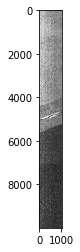

In [4]:
plt.imshow(image_array)

In [ ]:
print(image_array.shape)
joint_clr = 100
gap_clr = 200
maskImg = np.zeros((10000, 1024), np.uint8)

In [ ]:
anno_ids = coco.getAnnIds(imgIds=31748, catIds=[0], iscrowd=None)
anns = coco.loadAnns(anno_ids)
for ann in anns:
    pts = []  
    for seg in ann['segmentation']:
        for i in range(int(len(seg)/2)):
            pts.append([int(seg[i*2]), int(seg[i*2+1])])
    pts_np = np.array(pts, np.int32)
    if pts_np.size != 0:
        cv2.fillPoly(maskImg, [pts_np], joint_clr)

In [ ]:
anno_ids = coco.getAnnIds(imgIds=31748, catIds=[1], iscrowd=None)
anns = coco.loadAnns(anno_ids)
for ann in anns:
    pts = []  
    for seg in ann['segmentation']:
        for i in range(int(len(seg)/2)):
            pts.append([int(seg[i*2]), int(seg[i*2+1])])
    pts_np = np.array(pts, np.int32)
    if pts_np.size != 0:
        cv2.fillPoly(maskImg, [pts_np], gap_clr)

In [ ]:
plt.imshow(maskImg)

# Data preparation

In [ ]:
def masking(maskImg, ann, color):
    pts = [] 
    for seg in ann['segmentation']:
        for i in range(int(len(seg)/2)):
            pts.append([int(seg[i*2]), int(seg[i*2+1])])
    pts_np = np.array(pts, np.int32)
    if pts_np.size != 0:
        cv2.fillPoly(maskImg, [pts_np], color)
        
joint_clr = 100
gap_clr = 255
maskImg = np.zeros((10000, 1024), np.uint8)
        
anno_ids = coco.getAnnIds(imgIds=31748, catIds=[0], iscrowd=None)
anns = coco.loadAnns(anno_ids)
masking(maskImg, anns[0], joint_clr)

anno_ids = coco.getAnnIds(imgIds=31748, catIds=[1], iscrowd=None)
anns = coco.loadAnns(anno_ids)
masking(maskImg, anns[0], gap_clr)
plt.imshow(maskImg, cmap='gray')

In [ ]:
image_array = image_array[np.newaxis,...]
maskImg = maskImg[np.newaxis,...,np.newaxis]

In [ ]:
print(maskImg.shape)

In [ ]:
patches = tf.image.extract_patches(images=image_array,
                           sizes=[1, 1000, 1024, 1],
                           strides=[1, 500, 1, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
patches = tf.squeeze(patches)
patches = tf.reshape(patches, (19, 1000,1024,3))

mask_patches = tf.image.extract_patches(images=maskImg,
                           sizes=[1, 1000, 1024,1],
                           strides=[1, 500, 1, 1],
                           rates=[1, 1, 1,1],
                           padding='VALID')
mask_patches = tf.squeeze(mask_patches)
mask_patches = tf.reshape(mask_patches, (19, 1000,1024))

bbox = []
for ann in anns:
    x,y,w,h = ann["bbox"]
    x,y,w,h = x/2024,y/10000,w/2024,h/10000
    bbox.append([x,y,x+w,y+h])   
bbox = np.array(bbox)
    
boxes = np.zeros([19,4])
for i in range(19):
    boxes[i] = [0,0+0.05*i,1,0.1+0.05*i]
    
ious = compute_iou(bbox, boxes)
ious = np.sum(ious, axis=0)
ious = tf.squeeze(ious)
labels = tf.where(ious>0, 1, 0)

In [ ]:
plt.imshow(image_array[0])
plt.show()
print(image_array.shape)
print(patches.shape)
print(labels)

In [ ]:
indice = tf.squeeze(tf.where(labels))
indice

In [ ]:
tf.ones_like(indice)/len(indice)

In [ ]:
samples = tf.random.categorical(tf.math.log([tf.ones_like(indice)/len(indice)]), 100000)
samples

In [ ]:
tf.squeeze(tf.where(labels))[samples[0,0]]

In [ ]:
fig = plt.figure()
for i in range(20):
    if i != 19:
        ax = fig.add_subplot(5,4,i+1)
        ax.imshow(patches[i])

In [ ]:
fig = plt.figure()
for i in range(20):
    if i != 19:
        ax = fig.add_subplot(5,4,i+1)
        ax.imshow(mask_patches[i])